In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Setup in colab
!pip install cellpylib
!pip install pandas
!pip install scipy
!pip install pygad

  Preparing metadata (setup.py) ... done
  Created wheel for cellpylib: filename=cellpylib-2.4.0-py3-none-any.whl size=37921 sha256=7120955803228f897dfd865ee6262c50233c5547ba3b2b54445e558b374131ba
  Stored in directory: /root/.cache/pip/wheels/44/bc/c4/4730d328071b164c25d392c2d932b513e56ff0857da63d17e7
Successfully built cellpylib
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.9 MB/s eta 0:00:00


In [3]:
import cellpylib as cpl
import pandas as pd
import numpy as np
from random import random
from matplotlib import pyplot as plt
from scipy import stats
import pygad

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

- Tutorial from: https://cellpylib.org/working.html

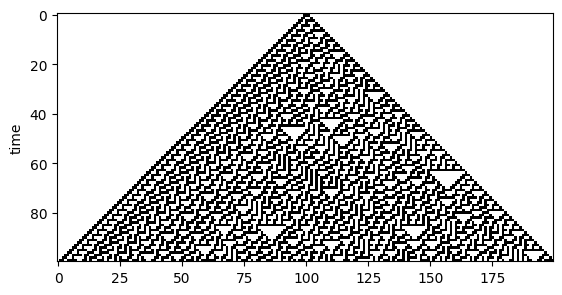

In [ ]:
cellular_automaton = cpl.init_simple(200)
cellular_automaton = cpl.evolve(cellular_automaton, timesteps=100, memoize=True,
                                apply_rule=lambda n, c, t: cpl.nks_rule(n, 30))
cpl.plot(cellular_automaton)

- Attempting to implement the discussed logic for CA-based dimensionality reduction

Cell state evolution accross iterations


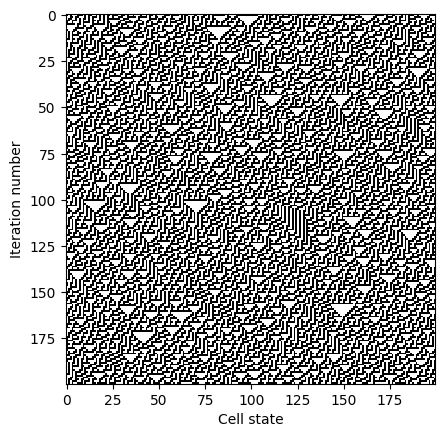

Data before dimensionality reduction


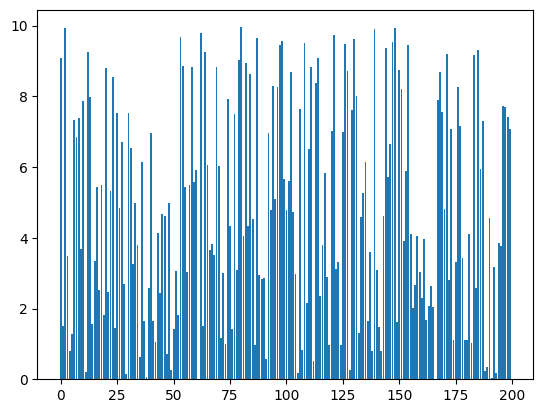

Initial number of dimensions: 200
Mean: 4.825676302072609
Median: 4.569074410345505
Mode: 0.00887743388974127
SD: 3.0372978805998496

Data after dimensionality reduction


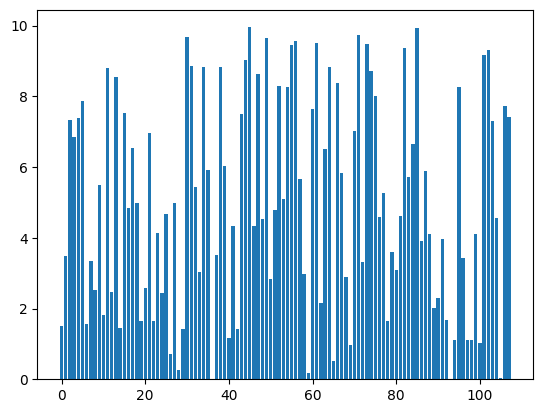

Rule number: 30
Total iterations: 200
Cell state index: -1
Number of dimensions preserved: 108
Mean: 5.065571555837624
Median: 4.813061610002281
Mode: 0.00887743388974127
SD: 3.000911405128644


In [ ]:
#Hyperparameters for demo
initial_dimensions = 200
num_iterations = 200
th_value = 4
rule_num = 30

#simulated random data
data = np.array([random()*10 for _ in range(initial_dimensions)])

#rule for converting input values to 1/0 based on thresholds
thresholds = lambda x: 0 if x < th_value else 1

#initalizing cellular automaton (see the tutorial)
ca_input = np.array([list(map(thresholds, data))])

#evolving the automaton
cellular_automaton = cpl.evolve(ca_input, timesteps=num_iterations, memoize=True,
                                apply_rule=lambda n, c, t: cpl.nks_rule(n, rule_num))

#plotting the state of cells at different stages of evolution
print('Cell state evolution accross iterations')
cpl.plot(cellular_automaton, xlabel='Cell state', ylabel='Iteration number')

#plotting the initial data across cells + summary statistics
print('Data before dimensionality reduction')
plt.bar(height=data, x=range(initial_dimensions))
plt.show()
print(f'Initial number of dimensions: {data.shape[0]}')
print(f'Mean: {np.mean(data)}')
print(f'Median: {np.median(data)}')
print(f'Mode: {stats.mode(data).mode}')
print(f'SD: {np.std(data)}')

#helper function
def plot_data_evolution(cellular_automaton, data, iteration_index, rule_num, calculate_only=False, calculate=False):
    '''Extracting and plotting the data in reduced dimensions using state of cells from given iteration_index.'''
    #extracting cell state after last iteration of evolution
    mask = cellular_automaton[iteration_index,:]

    #keeping based on the cell state after i of evolution
    dim_red_data = data[mask.astype(bool)]

    #calculating new number of dimensions
    new_size = len(dim_red_data)
    if calculate_only:
        return new_size

    #plotting the data after dim.reduction
    print('\nData after dimensionality reduction')
    plt.bar(height=dim_red_data, x=range(new_size))
    plt.show()
    print(f'Rule number: {rule_num}')
    print(f'Total iterations: {cellular_automaton.shape[1]}')
    print(f'Cell state index: {iteration_index}')
    print(f'Number of dimensions preserved: {dim_red_data.shape[0]}')
    print(f'Mean: {np.mean(dim_red_data)}')
    print(f'Median: {np.median(dim_red_data)}')
    print(f'Mode: {stats.mode(dim_red_data).mode}')
    print(f'SD: {np.std(dim_red_data)}')
    if calculate:
        return new_size

plot_data_evolution(cellular_automaton, data, rule_num=rule_num, iteration_index=-1)

# Creating a simple regression model baseline for [htagholdings](https://www.kaggle.com/datasets/htagholdings/property-sales) dataset.

# Data legend from [kaggle](https://www.kaggle.com/datasets/htagholdings/property-sales)
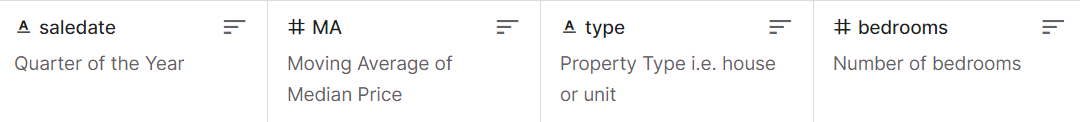

In [4]:
ts_dataset = pd.read_csv('/content/drive/MyDrive/ma_lga_12345.csv')

In [5]:
ts_dataset.describe()

,MA,bedrooms
count,3.470000e+02,347.000000
mean,5.481320e+05,2.867435
std,1.701934e+05,1.239875
min,3.167510e+05,1.000000
25%,4.277395e+05,2.000000
50%,5.077440e+05,3.000000
75%,6.275155e+05,4.000000
max,1.017752e+06,5.000000


In [6]:
ts_dataset.head(10)

,saledate,MA,type,bedrooms
0,30/09/2007,441854,house,2
1,31/12/2007,441854,house,2
2,31/03/2008,441854,house,2
3,30/06/2008,441854,house,2
4,30/09/2008,451583,house,2
5,31/12/2008,440256,house,2
6,31/03/2009,442566,house,2
7,30/06/2009,446113,house,2
8,30/09/2009,440123,house,2
9,31/12/2009,442131,house,2


In [7]:

# Convert date to a numerical feature (days since the start)
ts_dataset['saledate'] = pd.to_datetime(ts_dataset['saledate'], dayfirst=True)
ts_dataset['date_ordinal'] = (ts_dataset['saledate'] - ts_dataset['saledate'].min()).dt.days


# Assuming 'ts_dataset' contains 'saledate' and is not sorted
ts_dataset = ts_dataset.sort_values(by='date_ordinal')

# Assuming you want to use the first 80% of the data for training and the rest for testing
split_point = int(len(ts_dataset) * 0.8)
training_data = ts_dataset[:split_point]
testing_data = ts_dataset[split_point:]
data = ts_dataset.join(pd.get_dummies(ts_dataset['type'])).drop('type', axis=1)

# Prepare features and target variable for training and testing sets
X_train = data.drop(['MA', 'saledate'], axis=1)
y_train = data['MA']
X_test = data.drop(['MA', 'saledate'], axis=1)
y_test = data['MA']

# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 2126771987.4274466
R-squared: 0.9263642317593661


In [8]:
# Add predictions back to X_test for easy filtering
X_test_with_predictions = X_test.copy()
X_test_with_predictions['predictions'] = predictions

# Filter the actual and predicted values for 'house'
house_indices = X_test_with_predictions[X_test_with_predictions['house'] == 1].index
y_test_house = y_test.loc[house_indices]
predictions_house = X_test_with_predictions.loc[house_indices, 'predictions']

# Calculate and print MSE and R2 for 'house'
mse_house = mean_squared_error(y_test_house, predictions_house)
r2_house = r2_score(y_test_house, predictions_house)
print(f"House - Mean Squared Error: {mse_house}")
print(f"House - R-squared: {r2_house}")

# Filter the actual and predicted values for 'unit'
unit_indices = X_test_with_predictions[X_test_with_predictions['unit'] == 1].index
y_test_unit = y_test.loc[unit_indices]
predictions_unit = X_test_with_predictions.loc[unit_indices, 'predictions']

# Calculate and print MSE and R2 for 'unit'
mse_unit = mean_squared_error(y_test_unit, predictions_unit)
r2_unit = r2_score(y_test_unit, predictions_unit)
print(f"Unit - Mean Squared Error: {mse_unit}")
print(f"Unit - R-squared: {r2_unit}")

House - Mean Squared Error: 2677877766.3853645
House - R-squared: 0.903183362284398
Unit - Mean Squared Error: 1376968206.5323203
Unit - R-squared: 0.864515602708267


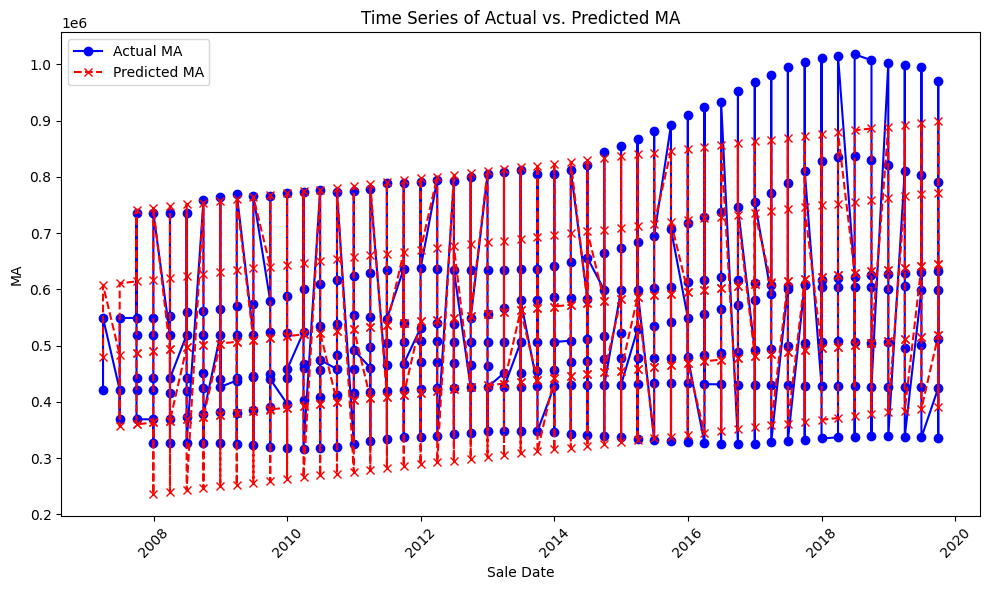

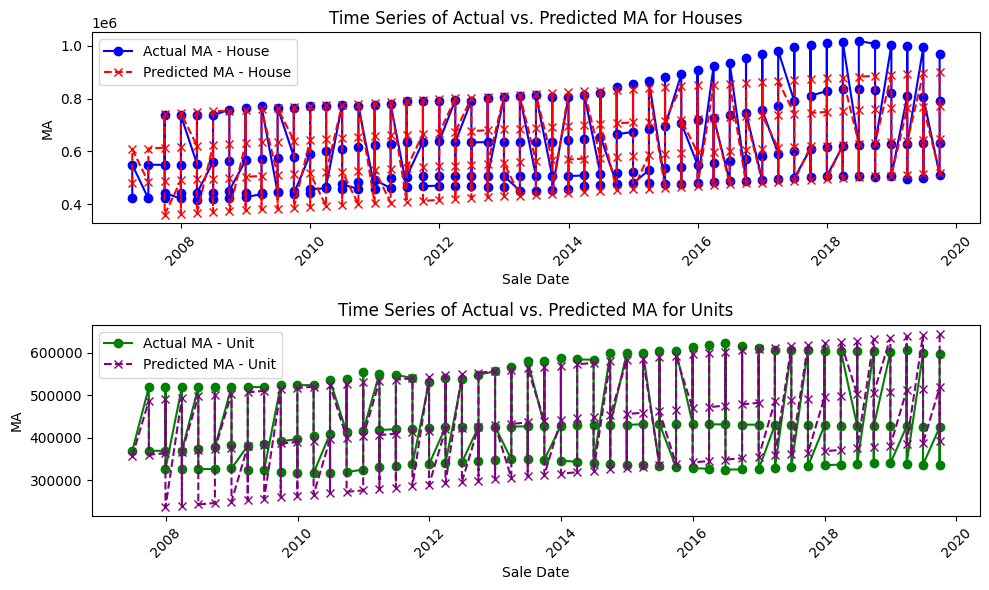

In [9]:
# First, we need to recover the actual sale dates from `date_ordinal`
min_date = ts_dataset['saledate'].min()  # Assuming `ts_dataset` is still accessible
X_test_sorted = X_test.copy()
X_test_sorted['predictions'] = predictions

# Convert `date_ordinal` back to datetime for plotting
X_test_sorted['saledate'] = pd.to_timedelta(X_test_sorted['date_ordinal'], unit='D') + min_date

# Now sort by `saledate`
X_test_sorted.sort_values('saledate', inplace=True)

# Recover the actual MA values for the sorted test set
actual_MA_sorted = y_test.reindex(X_test_sorted.index)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(X_test_sorted['saledate'], actual_MA_sorted, label='Actual MA', color='blue', marker='o')
plt.plot(X_test_sorted['saledate'], X_test_sorted['predictions'], label='Predicted MA', color='red', linestyle='--', marker='x')

plt.title('Time Series of Actual vs. Predicted MA')
plt.xlabel('Sale Date')
plt.ylabel('MA')
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated date labels
plt.show()

# Separate data for 'house' and 'unit'
house_data = X_test_sorted[X_test_sorted['house'] == 1]
unit_data = X_test_sorted[X_test_sorted['unit'] == 1]

# Recover the actual MA values for 'house' and 'unit'
actual_MA_house = y_test.reindex(house_data.index)
actual_MA_unit = y_test.reindex(unit_data.index)

# Plotting
plt.figure(figsize=(10, 6))

# Plot for 'house'
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
plt.plot(house_data['saledate'], actual_MA_house, label='Actual MA - House', color='blue', marker='o')
plt.plot(house_data['saledate'], house_data['predictions'], label='Predicted MA - House', color='red', linestyle='--', marker='x')
plt.title('Time Series of Actual vs. Predicted MA for Houses')
plt.xlabel('Sale Date')
plt.ylabel('MA')
plt.legend()
plt.xticks(rotation=45)

# Plot for 'unit'
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
plt.plot(unit_data['saledate'], actual_MA_unit, label='Actual MA - Unit', color='green', marker='o')
plt.plot(unit_data['saledate'], unit_data['predictions'], label='Predicted MA - Unit', color='purple', linestyle='--', marker='x')
plt.title('Time Series of Actual vs. Predicted MA for Units')
plt.xlabel('Sale Date')
plt.ylabel('MA')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# Attempting to implement alternative "smoothing" with CA approach

In [10]:
# Taking unaggregated time series data
raw_sales = pd.read_csv('/content/drive/MyDrive/raw_sales.csv')

In [11]:
# Exploring
raw_sales.head(10)

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07 00:00:00,2607,525000,house,4
1,2007-02-27 00:00:00,2906,290000,house,3
2,2007-03-07 00:00:00,2905,328000,house,3
3,2007-03-09 00:00:00,2905,380000,house,4
4,2007-03-21 00:00:00,2906,310000,house,3
5,2007-04-04 00:00:00,2905,465000,house,4
6,2007-04-24 00:00:00,2607,399000,house,3
7,2007-04-30 00:00:00,2606,1530000,house,4
8,2007-05-24 00:00:00,2902,359000,house,3
9,2007-05-25 00:00:00,2906,320000,house,3


In [12]:
# Preprocessing
data = raw_sales.copy()
data['datesold'] = pd.to_datetime(data['datesold'], dayfirst=True)
processed_data = data.join(pd.get_dummies(data['propertyType'])).drop(['propertyType', 'postcode'], axis=1)
rs_min_date = processed_data['datesold'].min() #saving for visualization of CA results
processed_data['date_ordinal'] = (processed_data['datesold'] - processed_data['datesold'].min()).dt.days
processed_data = processed_data.drop('datesold', axis=1)
display(processed_data)

,price,bedrooms,house,unit,date_ordinal
0,525000,4,1,0,0
1,290000,3,1,0,20
2,328000,3,1,0,28
3,380000,4,1,0,30
4,310000,3,1,0,42
...,...,...,...,...,...
29575,500000,3,0,1,4551
29576,560000,2,0,1,4551
29577,464950,2,0,1,4552
29578,589000,2,0,1,4552


In [13]:
def evolve_data(data, controlled_vars, threshold_values, rule_numbers, num_iterations, rounds):
  '''Perform several rounds of dimentionality reduction with selected one-dimentional cellular automaton.'''
  for round in range(rounds):
    print(f'\nRound {round+1}/{rounds} of CA evolution')
    print(f'Controlled attribute: {controlled_vars[round]}')
    print(f'Threshold value: {threshold_values[round]}')
    print(f'Rule number: {rule_numbers[round]}')
    print(f'Number of iterations: {num_iterations[round]}')
    vector = data[controlled_vars[round]].to_numpy()

    #rule for converting input values to 1/0 based on thresholds
    thresholds = lambda x: 0 if x < threshold_values[round] else 1


    #initalizing cellular automaton (see the tutorial)
    ca_input = np.array([list(map(thresholds, vector))])

    #evolving the automaton
    cellular_automaton = cpl.evolve(ca_input, timesteps=num_iterations[round], memoize=True,
                                    apply_rule=lambda n, c, t: cpl.nks_rule(n, rule_numbers[round]))
    cpl.plot(cellular_automaton, ylabel='', aspect='auto')


    #extracting cell state after last iteration of evolution
    mask = cellular_automaton[-1,:]

    #keeping based on the cell state after i of evolution
    dim_red_data = data.iloc[mask.astype(bool)]
    data = dim_red_data

    print(f'Number of dimensions remaining: {len(data)}')
  return data


Round 1/3 of CA evolution
Controlled attribute: date_ordinal
Threshold value: 1506
Rule number: 30
Number of iterations: 198


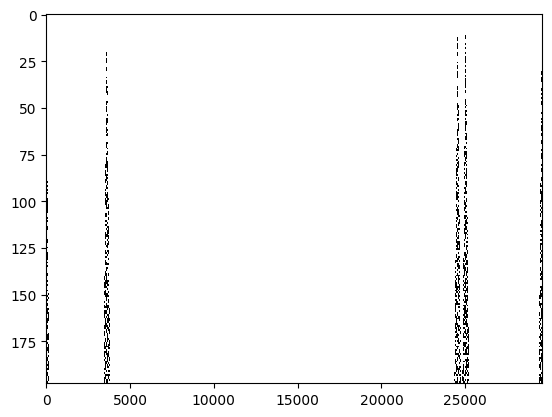

Number of dimensions remaining: 754

Round 2/3 of CA evolution
Controlled attribute: date_ordinal
Threshold value: 1506
Rule number: 30
Number of iterations: 198


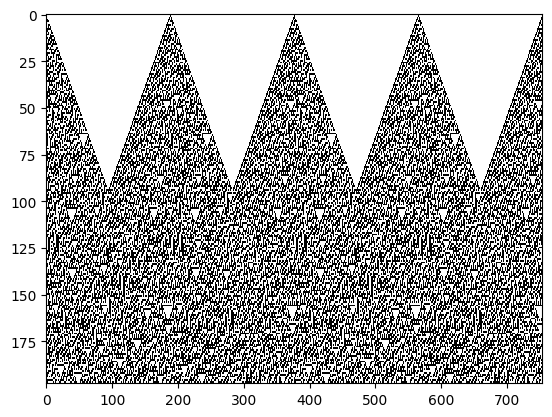

Number of dimensions remaining: 392

Round 3/3 of CA evolution
Controlled attribute: date_ordinal
Threshold value: 1506
Rule number: 30
Number of iterations: 198


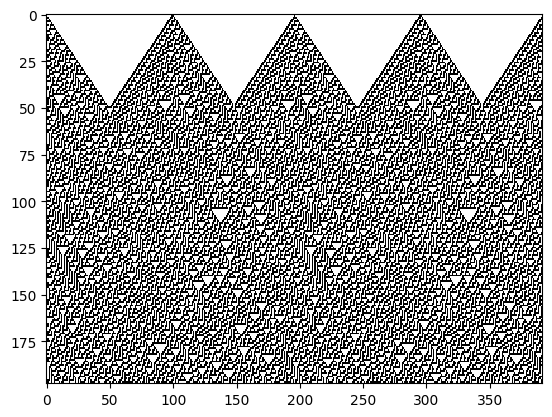

Number of dimensions remaining: 210


In [15]:
# Testing the function
rounds = 3
evolved_data = evolve_data(
    data = processed_data,
    controlled_vars = ['date_ordinal']*rounds,
    threshold_values = [1506]*rounds,
    rule_numbers = [30]*rounds,
    num_iterations = [198]*rounds,
    rounds = rounds
    )

In [16]:
# Restoring absolute dates
evolved_data['saledate'] = pd.to_timedelta(evolved_data['date_ordinal'], unit='D') + rs_min_date
# Ordering by date for plotting
evolved_data = evolved_data.sort_values(by='saledate')

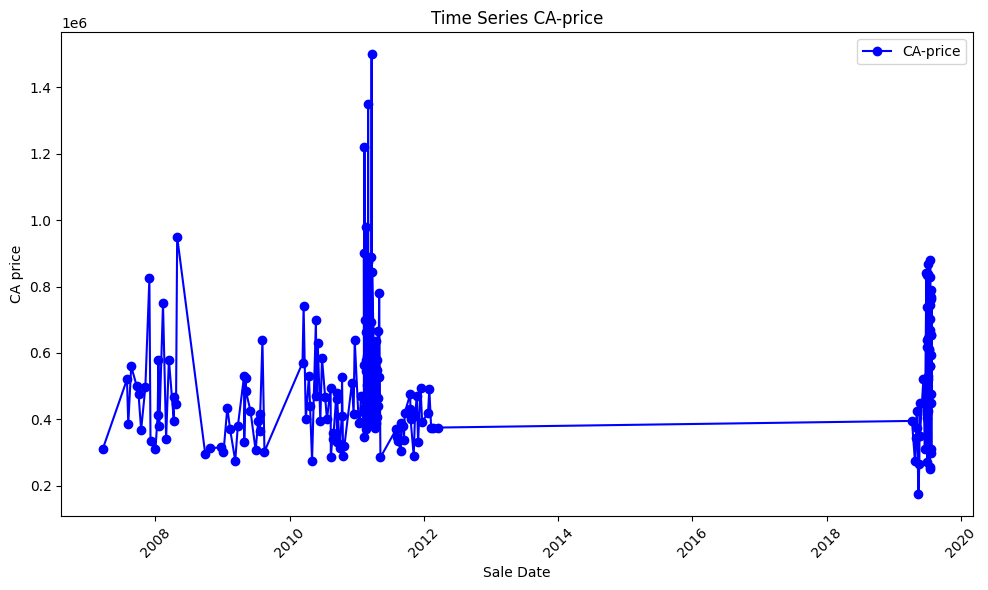

In [17]:
# Visualizing
plt.figure(figsize=(10, 6))
plt.plot(evolved_data['saledate'], evolved_data['price'], label='CA-price', color='blue', marker='o')

plt.title('Time Series CA-price')
plt.xlabel('Sale Date')
plt.ylabel('CA price')
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated date labels
plt.show()

In [18]:
# Testing regression performance
# Prepare features and target variable
X = evolved_data.drop(['price', 'saledate'], axis=1)  # Features
y = evolved_data['price']  # Target variable


# Assuming you want to use the first 80% of the data for training and the rest for testing
split_point = int(len(evolved_data) * 0.8)
training_data = evolved_data[:split_point]
testing_data = evolved_data[split_point:]

# Prepare features and target variable for training and testing sets
X_train = data.drop(['price'], axis=1)
y_train = data['price']
X_test = data.drop(['price'], axis=1)
y_test = data['price']

# Split the dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 22926610859.304745
R-squared: 0.48371063990387886


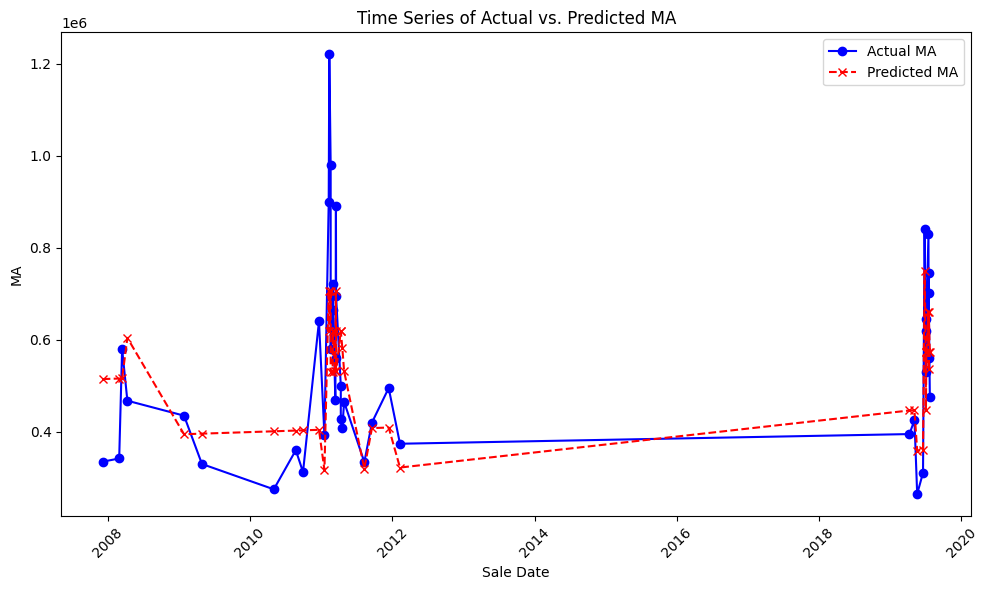

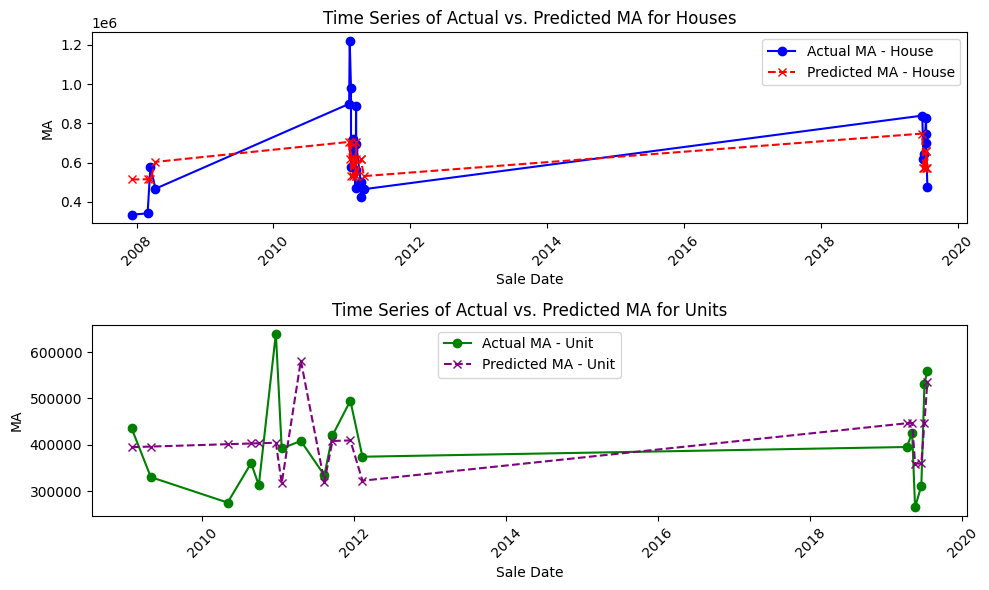

In [19]:
# First, we need to recover the actual sale dates from `date_ordinal`
X_test_sorted = X_test.copy()
X_test_sorted['predictions'] = predictions

# Convert `date_ordinal` back to datetime for plotting
X_test_sorted['saledate'] = pd.to_timedelta(X_test_sorted['date_ordinal'], unit='D') + rs_min_date

# Now sort by `saledate`
X_test_sorted.sort_values('saledate', inplace=True)

# Recover the actual MA values for the sorted test set
actual_MA_sorted = y_test.reindex(X_test_sorted.index)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(X_test_sorted['saledate'], actual_MA_sorted, label='Actual MA', color='blue', marker='o')
plt.plot(X_test_sorted['saledate'], X_test_sorted['predictions'], label='Predicted MA', color='red', linestyle='--', marker='x')

plt.title('Time Series of Actual vs. Predicted MA')
plt.xlabel('Sale Date')
plt.ylabel('MA')
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated date labels
plt.show()

# Separate data for 'house' and 'unit'
house_data = X_test_sorted[X_test_sorted['house'] == 1]
unit_data = X_test_sorted[X_test_sorted['unit'] == 1]

# Recover the actual MA values for 'house' and 'unit'
actual_MA_house = y_test.reindex(house_data.index)
actual_MA_unit = y_test.reindex(unit_data.index)

# Plotting
plt.figure(figsize=(10, 6))

# Plot for 'house'
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
plt.plot(house_data['saledate'], actual_MA_house, label='Actual MA - House', color='blue', marker='o')
plt.plot(house_data['saledate'], house_data['predictions'], label='Predicted MA - House', color='red', linestyle='--', marker='x')
plt.title('Time Series of Actual vs. Predicted MA for Houses')
plt.xlabel('Sale Date')
plt.ylabel('MA')
plt.legend()
plt.xticks(rotation=45)

# Plot for 'unit'
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
plt.plot(unit_data['saledate'], actual_MA_unit, label='Actual MA - Unit', color='green', marker='o')
plt.plot(unit_data['saledate'], unit_data['predictions'], label='Predicted MA - Unit', color='purple', linestyle='--', marker='x')
plt.title('Time Series of Actual vs. Predicted MA for Units')
plt.xlabel('Sale Date')
plt.ylabel('MA')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Cross-validation settings
  - Number of CA rounds
  - Rule number at each round
  - Controlled attribute at each round
  - Threshold values at each round
  - Number of CA iterations at each round
- Target function - MSE
- Potential solution - genetic algorithm

In [30]:
def evolve_data_ga(data, controlled_vars, threshold_values, rule_numbers, num_iterations, rounds):
  '''Perform several rounds of dimentionality reduction with selected one-dimentional cellular automaton.'''
  for round in range(rounds):
    # print(f'\nRound {round+1}/{rounds} of CA evolution')
    # print(f'Controlled attribute: {controlled_vars[round]}')
    # print(f'Threshold value: {threshold_values[round]}')
    # print(f'Rule number: {rule_numbers[round]}')
    # print(f'Number of iterations: {num_iterations[round]}')
    vector = data[controlled_vars[round]].to_numpy()

    #rule for converting input values to 1/0 based on thresholds
    thresholds = lambda x: 0 if x < threshold_values[round] else 1


    #initalizing cellular automaton (see the tutorial)
    ca_input = np.array([list(map(thresholds, vector))])

    #evolving the automaton
    cellular_automaton = cpl.evolve(ca_input, timesteps=num_iterations[round], memoize=True,
                                    apply_rule=lambda n, c, t: cpl.nks_rule(n, rule_numbers[round]))
    # cpl.plot(cellular_automaton, ylabel='', aspect='auto')


    #extracting cell state after last iteration of evolution
    mask = cellular_automaton[-1,:]

    #keeping based on the cell state after i of evolution
    dim_red_data = data.iloc[mask.astype(bool)]
    data = dim_red_data
    # print(f'Number of dimensions remaining: {len(data)}')
  try:
    # Saving parameters of the model to optimize via GA
    param_list = sum([threshold_values, rule_numbers, num_iterations],[])

    # Testing regression performance
    # Prepare features and target variable
    X = data.drop(['price'], axis=1)  # Features
    y = data['price']  # Target variable


    # Assuming you want to use the first 80% of the data for training and the rest for testing
    split_point = int(len(data) * 0.8)
    training_data = data[:split_point]
    testing_data = data[split_point:]

    # Prepare features and target variable for training and testing sets
    X_train = training_data.drop(['price'], axis=1)
    y_train = training_data['price']
    X_test = testing_data.drop(['price'], axis=1)
    y_test = testing_data['price']

    # Create a linear regression model
    model = LinearRegression()

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    predictions = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, predictions)
    # print(f'Resulting MSE value: {mse}')
  except ValueError as e:
    print(e)
    mse = -1e1000
  return data, param_list, mse

In [31]:
# Testing the function
rounds = 3
evolved_data = evolve_data_ga(
    data = processed_data,
    controlled_vars = ['date_ordinal']*rounds,
    threshold_values = [1506]*rounds,
    rule_numbers = [30]*rounds,
    num_iterations = [198]*rounds,
    rounds = rounds
    )
evolved_data

(        price  bedrooms  house  unit  date_ordinal
 4      310000         3      1     0            42
 30     520000         4      1     0           174
 43     560000         4      1     0           197
 61     500000         4      1     0           227
 66     475000         3      1     0           237
 ...       ...       ...    ...   ...           ...
 29553  250000         1      0     1          4543
 29559  560000         3      0     1          4544
 29562  310000         1      0     1          4549
 29564  450000         3      0     1          4549
 29571  297500         2      0     1          4551
 
 [210 rows x 5 columns],
 [1506, 1506, 1506, 30, 30, 30, 198, 198, 198],
 13119416705.82667)

In [32]:
# Assuming 'rounds' is defined
rounds = 5

# Define the parameter space
threshold_values_range = np.linspace(1500, 1550, num=(1550-1500+1))  # Adjust granularity as needed
rule_numbers_range = np.arange(30, 35+1)  # 30 to 35 inclusive
iterations_range = np.arange(195, 200+1)  # 195 to 200 inclusive


In [33]:
def evaluate_parameters(params, data, rounds):
    thv, rn, ni = params
    threshold_values = [thv] * rounds
    rule_numbers = [rn] * rounds
    num_iterations = [ni] * rounds
    try:
        output = evolve_data_ga(
            data=data,
            controlled_vars=['date_ordinal'] * rounds,
            threshold_values=threshold_values,
            rule_numbers=rule_numbers,
            num_iterations=num_iterations,
            rounds=rounds
        )

        fitness = output[-1]

        return fitness, threshold_values, rule_numbers, num_iterations
    except ValueError as e:
        return np.inf, threshold_values, rule_numbers, num_iterations

In [34]:
from concurrent.futures import ProcessPoolExecutor
from itertools import product

def custom_cross_validation(data, rounds, threshold_values_range, rule_numbers_range, iterations_range):
    parameter_combinations = list(product(threshold_values_range, rule_numbers_range, iterations_range))

    best_score = np.inf
    best_params = None

    # Use ProcessPoolExecutor to parallelize the evaluation
    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(evaluate_parameters, params, data, rounds) for params in parameter_combinations]
        for future in futures:
            fitness, thv, rn, ni = future.result()
            print(f'Finished calculation for {(thv, rn, ni)}: {fitness}')
            if fitness < best_score:
                best_score = fitness
                best_params = (thv, rn, ni)
                print(f'Improvement: {best_params}, {best_score}')

    return best_params, best_score

In [ ]:
best_params, best_score = custom_cross_validation(
    processed_data, rounds, threshold_values_range, rule_numbers_range, iterations_range
    )
print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")


Finished calculation for ([1500.0, 1500.0, 1500.0, 1500.0, 1500.0], [30, 30, 30, 30, 30], [195, 195, 195, 195, 195]): 8973682263.44126
Improvement: ([1500.0, 1500.0, 1500.0, 1500.0, 1500.0], [30, 30, 30, 30, 30], [195, 195, 195, 195, 195]), 8973682263.44126
Finished calculation for ([1500.0, 1500.0, 1500.0, 1500.0, 1500.0], [30, 30, 30, 30, 30], [196, 196, 196, 196, 196]): 27954896746.96261
Finished calculation for ([1500.0, 1500.0, 1500.0, 1500.0, 1500.0], [30, 30, 30, 30, 30], [197, 197, 197, 197, 197]): 23245918533.01642
Finished calculation for ([1500.0, 1500.0, 1500.0, 1500.0, 1500.0], [30, 30, 30, 30, 30], [198, 198, 198, 198, 198]): 14515603926.401833
Finished calculation for ([1500.0, 1500.0, 1500.0, 1500.0, 1500.0], [30, 30, 30, 30, 30], [199, 199, 199, 199, 199]): 15846637670.346825
Finished calculation for ([1500.0, 1500.0, 1500.0, 1500.0, 1500.0], [30, 30, 30, 30, 30], [200, 200, 200, 200, 200]): 9130902488.818893
